In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report, precision_recall_curve
from scikitplot.metrics import plot_precision_recall
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from itertools import product

# Neural Network

In [2]:
class NeuralNetwork:
    """
    ### Description 
    Implementation of an Artificial Neural Network designed for binary classification using numpy, and it implements 
    common techniques and algorithms to improve the performance and convergence.

    ### Features
    - Different activation functions
    - Weight initialization techniques
    - Implementation of common optimization algorithms
    - Learing rate decay strategies
    - Regularization to prevent overfitting
    - Plots of loss and accuracy curves
    - Outputs of nn_predict and nn_predict_proba are compatible with sklearn.metrics functions

    ### Usage
    1. Initialize NeuralNetwork Object with desired parameters, if none are specified, default parameters will be used.
    2. Train the model with nn_train(). Specify verbose=False as an argument in nn_train to hide loss and accuracy for each epoch
    3. Generate predictions with nn_predict(), and obtain prediction probabilities with nn_predict_proba()
    4. Visualize loss and accuracuy plots()

    ### Dependencies
    - numpy
        - np.seterr is used to prevent warning from showing during neural network training. All errors are appropriately handled.
    - matplotlib
    - sklearn

    ### Arguments
    - activation_func (str): Activation function for hidden layers and output (tanh, sigmoid, relu, linear)
        - Default: 'relu'
    - hidden_layer_sizes (List[int]): List of number of neurons in each hidden layer
        - Default: [100, 100, 100]
    - initialization (str): Method used to initalize the weights (he, xavier, random)
        - Initialization formula determines how weights are initialized
        - Default: 'he'
    - epochs (int): Number of training iterations
        - Default: 50
    - optimizer (str): Optimization algorithm (adam, sgd)
        - Optimizer used to update weights and biases during training
        - Default: 'adam'
    - learning_rate (float): Specifies the learning rate for gradient descent
        - Default: 0.01
    - lr_decay_type (str): Learning rate decay strategy (step, exponential, time)
        - Formula to dynamically adjust the learning rate during training
        - If lr_decrease or lr_epoch_drop is 0, then constant learning rate is used.
        - Default: 'constant'
    - lr_decrease (float): Value to decrease learning rate by in specified decay type
        - Use when decay_type is not constant
        - Default: 0.5
    - lr_epoch_drop (int): Epoch at which to drop the learning rate
        - Use when decay_type is not constant
        - Default: 5
    - alpha (float): Regularization term to prevent overfitting
        - Default: 0.01
    - regularization (str): Type of regularization (l1, l2, none)
        - Regularization method applied to the network to prevent overfitting
        - Default: 'l2'
    - tolerance (float): Tolerance used to determine early convergence
        - Default: 0.0001
    - tolerance_counter (int): Tolerance count to end Neural Network training
        - Default: 10
    - beta_1 (float): Control first moment value (mean) for adam optimizer
        - Use only when optimizer='adam'
        - Default: 0.9
    - beta_2 (float): Control second moment value (variance) for adam optimizer
        - Use only when optimizer='adam'
        - Default: 0.999
    - epsilon (float): To prevent division by 0 when using adam optimizer
        - Use only when optimizer='adam'
        - Default: 1e-8
    - random_state (int): Sets numpy seed to allow for reproducable results
        - Default: None

    ### Example:
    ```
    # Required imports
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import accuracy_score

    # Optional imports
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import precision_score, confusion_matrix, classification_report, precision_recall_curve
    import scikitplot as skplot

    # Using X as dataframe with features and y as the target feature with binary class
    neural_net = NeuralNetwork(activation_func='sigmoid', hidden_layer_sizes=[20, 20, 20],
                               initialization='random', epochs=50, optimizer='adam', 
                               learning_rate=0.01, lr_decay_type='constant', random_state=18)
    
    X = df_features
    y = df_target.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

    fit = neural_net.nn_train(X_train, y_train)

    # get training predictions
    y_pred_train = neural_net.nn_train(X_train)

    # get testing predictions
    y_pred_test = neural_net.nn_predict(X_test)

    # get class probability predictions
    pred_proba = neural_net.nn_predict_proba(X_test)

    # plotting the loss and accuracy curves for training
    neural_net.plots()

    # confusion matrix, classification report, auRoc curves
    print(classification_report(y_test, y_pred_test))
    skplt.metrics.plot_confusion_matrix(y_test, y_pred_test)
    skplt.metrics.plot_roc(y_test, pred_proba)
    plot_precision_recall(y_test, pred_proba)
    plt.show()
    ```
    """

    def __init__(self, activation_func='relu', hidden_layer_sizes=[100, 100, 100], 
                 initialization='he', epochs=100, optimizer='adam',
                 learning_rate=0.01, lr_decay_type='constant', lr_decrease=0.5, 
                 lr_epoch_drop=5, alpha=0.01, regularization='l2',
                 tolerance = 0.0001, tolerance_counter = 10, beta_1 = 0.9,
                 beta_2 = 0.999, epsilon=1e-8, random_state=None):
        self.activation_func = activation_func
        self.hidden_layer_sizes = hidden_layer_sizes
        self.initialization = initialization
        self.epochs = epochs
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.lr_decay_type = lr_decay_type
        self.lr_decrease = lr_decrease
        self.lr_epoch_drop = lr_epoch_drop
        self.alpha = alpha
        self.regularization = regularization
        self.tolerance = tolerance
        self.tolerance_counter = tolerance_counter
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.random_state = random_state

        np.seterr(all='ignore')
        np.random.seed(self.random_state)
    
    # sets the parameters for the NeuralNetwork object. Argument passed is a dictionary
    def set_params(self, params):
        for k, v in params.items():
            if hasattr(self, k):
                setattr(self, k, v)
            else:
                raise KeyError(f"Invalid parameter: {k}")
        
        np.random.seed(self.random_state)

    # Returns the parameters of the object
    def get_params(self):
        params = {
            'activation_func': self.activation_func,
            'hidden_layer_sizes': self.hidden_layer_sizes,
            'initialization': self.initialization,
            'epochs': self.epochs,
            'optimizer': self.optimizer,
            'learning_rate': self.learning_rate,
            'lr_decay_type': self.lr_decay_type,
            'lr_decrease': self.lr_decrease,
            'lr_epoch_drop': self.lr_epoch_drop,
            'alpha': self.alpha,
            'regularization': self.regularization,
            'tolerance': self.tolerance,
            'tolerance_counter': self.tolerance_counter,
            'beta_1': self.beta_1,
            'beta_2': self.beta_2,
            'epsilon': self.epsilon,
            'random_state': self.random_state
        }

        return params
    
    # Defining all the common activation functions and their derivatives
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_ddx(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_ddx(self, x):
        return (1 - (self.tanh(x))**2)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_ddx(self, x):
        return np.where(x < 0, 0, 1)

    def linear(self, x):
        return x

    def linear_ddx(self, x):
        return x**0
    
    # Allows the learning rate to vary with the number of epochs to allow for better convergence
    def learning_rate_scheduler(self, learning_rate, decay_type, decrease_value, epoch_drop):
        final_lr = 0

        if decrease_value == 0 or epoch_drop == 0:
            final_lr = learning_rate
        else:
            if decay_type == 'exponential':
                drop_factor = np.power(decrease_value, np.floor(self.epoch / epoch_drop))
                final_lr = learning_rate * drop_factor
            elif decay_type == 'time':
                drop_factor = (1 / (1 + decrease_value * np.floor(self.epoch / epoch_drop)))
                final_lr = learning_rate * drop_factor
            elif decay_type == 'step':
                drop_factor = np.power(decrease_value, np.floor((1 + self.epoch) / epoch_drop))
                final_lr = learning_rate * drop_factor
            else:
                final_lr = learning_rate

        return final_lr

    # Definining loss function for binary prediction
    def log_loss(self, y_actual, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        loss = -np.mean(y_actual * np.log(y_pred) + (1 - y_actual) * np.log(1 - y_pred))
        
        return loss
    
    # Defining different intialization functions to help with convergence
    def xavier_initialization(self, input_size, output_size):
        bound = np.sqrt(6.0 / (input_size + output_size))
        weights = np.random.normal(-bound, bound, size=(input_size, output_size))

        return weights
    
    def he_initialization(self, input_size, output_size):
        std_dev = np.sqrt(2.0 / input_size)
        weights = np.random.normal(0, std_dev, size=(input_size, output_size))

        return weights
    
    def random_initialization(self, input_size, output_size):
        weights = np.random.randn(input_size, output_size)

        return weights

    # Initializing the weights and biases based on the number of sizes in input, hidden and output layers and the initialization method
    def weights_biases(self, input_size, hidden_layer_sizes, output_size, initialization):
        size = [input_size] + hidden_layer_sizes + [output_size]
        
        initialization_formulas = {
            'xavier': self.xavier_initialization,
            'he': self.he_initialization,
            'random': self.random_initialization
        }
        weights = [initialization_formulas[initialization](size[i], size[i + 1]) for i in range(len(size) - 1)]
        biases = [np.zeros((1, size[i + 1])) for i in range(len(size) - 1)]

        return weights, biases

    # Runs the forward pass of the neural network to get to the output layer
    def forward_propagation(self, X, weights, biases, activation_func):
        activations = [X]

        activation_functions = {
            'tanh': self.tanh,
            'sigmoid': self.sigmoid,
            'relu': self.relu,
            'linear': self.linear
        }
        
        for i in range(len(weights)):
            input_weighted = np.dot(activations[-1], weights[i]) + biases[i]
            output_activation = activation_functions[activation_func](input_weighted)
            activations.append(output_activation)

        return activations

    # Runs the backward pass and computes the updated weights and biases, adn includes regularization to prevent overfitting
    # Accounts for the derivative of the specified activation function
    def back_propagation(self, X, y, activations, weights, activation_func, alpha, regularization):
        len_X = X.shape[1]
        deltas = [activations[-1] - y]

        activation_functions_ddx = {
            'tanh': self.tanh_ddx,
            'sigmoid': self.sigmoid_ddx,
            'relu': self.relu_ddx,
            'linear': self.linear_ddx
        }
        
        for i in range(len(weights) -1 , 0, -1):
            input_weighted_ddx = np.dot(deltas[-1], weights[i].T)
            output_activation_ddx = activation_functions_ddx[activation_func](activations[i])
            
            delta = input_weighted_ddx * output_activation_ddx
            deltas.append(delta)

        deltas.reverse()

        if regularization == 'l1':
            weights_ddx = [(np.dot(activations[i].T, deltas[i]) + alpha * np.sign(weights[i])) / len_X for i in range(len(weights))]
        elif regularization == 'l2':
            weights_ddx = [(np.dot(activations[i].T, deltas[i]) + 2 * alpha * weights[i]) / len_X for i in range(len(weights))]
        else:
            weights_ddx = [(np.dot(activations[i].T, deltas[i])) / len_X for i in range(len(weights))]
        
        biases_ddx = [np.sum(deltas[i], axis=0, keepdims=True) / len_X for i in range(len(weights))]

        return weights_ddx, biases_ddx
    
    # Standard optimizer used to compute the weights adn biases
    def sgd_optimizer(self, weights, biases, weights_ddx, biases_ddx, learning_rate):
        for i in range(len(weights)):
            weights[i] -= learning_rate * weights_ddx[i]
            biases[i] -= learning_rate * biases_ddx[i]

        return weights, biases

    # A better optimizer that uses the moment generating function, means, and variances to converge. Hyperparameters
    # can be changes as needed when initalizing the object
    def adam_optimizer(self, weights, biases, weights_ddx, biases_ddx, learning_rate):
        mean_weights = [np.zeros_like(w) for w in weights]
        var_weights = [np.zeros_like(w) for w in weights]
        mean_biases = [np.zeros_like(b) for b in biases]
        var_biases = [np.zeros_like(b) for b in biases]

        for i in range(len(weights)):
            mean_weights[i] = self.beta_1 * mean_weights[i] + (1 - self.beta_1) * weights_ddx[i]
            var_weights[i] = self.beta_2 * var_weights[i] + (1 - self.beta_2) * (weights_ddx[i]**2)
            mean_biases[i] = self.beta_1 * mean_biases[i] + (1 - self.beta_1) * biases_ddx[i]
            var_biases[i] = self.beta_2 * var_biases[i] + (1 - self.beta_2) * (biases_ddx[i]**2)

            mean_weights_hat = mean_weights[i] / (1 - np.power(self.beta_1, (self.epoch + 1)))
            var_weights_hat = var_weights[i] / (1 - np.power(self.beta_2, (self.epoch + 1)))
            mean_biases_hat = mean_biases[i] / (1 - np.power(self.beta_1, (self.epoch + 1)))
            var_biases_hat = var_biases[i] / (1 - np.power(self.beta_2, (self.epoch + 1)))

            weights[i] -= learning_rate * mean_weights_hat / (np.sqrt(var_weights_hat) + self.epsilon)
            biases[i] -= learning_rate * mean_biases_hat / (np.sqrt(var_biases_hat) + self.epsilon)
        
        return weights, biases

    # Trains the neural network and runs the forward and backward passes. Early stopping was included to prevent long run times
    # and for faster convergence
    def nn_train(self, X, y, verbose=True):
        input_size = X.shape[1]
        output_size = y.shape[1]
        
        self.losses = []
        self.accuracies = []
        self.epoch = 0
        self.weights, self.biases = self.weights_biases(input_size, self.hidden_layer_sizes, output_size, self.initialization)

        optimizers = {
            'adam': self.adam_optimizer,
            'sgd': self.sgd_optimizer
        }

        loss_prev = np.inf
        tol_counter = 0

        for _ in range(self.epochs):
            activations = self.forward_propagation(X, self.weights, self.biases, self.activation_func)
            weights_ddx, biases_ddx = self.back_propagation(X, y, activations, self.weights, self.activation_func, self.alpha, self.regularization)

            y_pred = activations[-1]
            loss = self.log_loss(y, y_pred)
            
            if np.isnan(y_pred).any() or np.isnan(loss):
                print("WARNING: Training stopped due to NaN values in computation. Please adjust Hyperparameters.")
                loss = 0
                break
            
            loss_change = loss_prev - loss
            if abs(loss_change) < self.tolerance:
                tol_counter += 1
            else:
                tol_counter = 0
            
            if tol_counter >= self.tolerance_counter:
                print(f"WARNING: Training stopped due to {tol_counter} consecutive epochs with no change in loss.")
                break

            if self.activation_func == 'sigmoid':
                accuracy = accuracy_score(y, np.round(y_pred))
            else:
                accuracy = accuracy_score(y, np.round(self.sigmoid(y_pred)))

            current_learning_rate = self.learning_rate_scheduler(self.learning_rate, self.lr_decay_type, self.lr_decrease, self.lr_epoch_drop)
            weights_ddx, biases_ddx = self.back_propagation(X, y, activations, self.weights, self.activation_func, self.alpha, self.regularization)
            self.weights, self.biases = optimizers[self.optimizer](self.weights, self.biases, weights_ddx, biases_ddx, learning_rate=current_learning_rate)
            
            if verbose == True:
                print(f"Epoch {self.epoch + 1:3d} ==================> Loss: {loss:7.4f}, Accuracy: {accuracy:6.4f}")
            
            loss_prev = loss
            self.accuracies.append(accuracy)
            self.losses.append(loss)

            self.epoch += 1
            
        return self.weights, self.biases

    # Runs a final forward pass with the best weights and biases to make predictions
    def nn_predict(self, X):
        outputs = self.forward_propagation(X, self.weights, self.biases, self.activation_func)
        self.class_outputs = outputs[-1]
        
        if self.activation_func == 'sigmoid':
            y_pred = np.nan_to_num(np.round(self.class_outputs))
        else:
            y_pred = np.nan_to_num(np.round(self.sigmoid(self.class_outputs)))
        
        return y_pred

    # Gets the predicition probabilites of the classes
    def nn_predict_proba(self, X=None):
        if X is not None:
            logits = self.forward_propagation(X, self.weights, self.biases, self.activation_func)[-1]
        else:
            logits = self.class_outputs
        
        sigmoid_logits = self.sigmoid(logits)

        prob_neg_class = sigmoid_logits
        prob_pos_class = 1 - sigmoid_logits

        prediction_probabilities = np.nan_to_num(np.column_stack((prob_neg_class, prob_pos_class)))

        return prediction_probabilities
    
    # Creates the plots of loss and training curves from nn_train
    def plots(self):
        if len(self.losses) > 100:
            fig, axs = plt.subplots(2, 1, figsize=(8, 4))
        else:
            fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].plot(self.losses, label='Loss', color='#1f77b4')
        axs[0].set_xlabel("Epochs")
        axs[0].set_title("Loss (Train)")

        axs[1].plot(self.accuracies, label='Accuracy', color='green')
        axs[1].set_xlabel("Epochs")
        axs[1].set_title("Accuracy (Train)")

        fig.tight_layout()
        plt.show()

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/gs1803/CS4375-Datasets/main/heart_attack_prediction_dataset.csv")

# Cleaning the Data

In [4]:
df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)

In [5]:
df = df.drop(['Patient ID', 'Blood Pressure', 'Country', 'Continent'], axis=1)

In [6]:
df = pd.get_dummies(df, dtype=int)
df = df.rename(columns={'Sex_Female': 'Gender', 'Hemisphere_Northern Hemisphere': 'Hemisphere'})

In [7]:
df = df.drop(['Sex_Male', 'Hemisphere_Southern Hemisphere'], axis=1)

In [8]:
df = df[['Age', 'Gender', 'Diet_Average', 'Diet_Healthy', 'Diet_Unhealthy',
         'Hemisphere', 'Cholesterol', 'Systolic', 'Diastolic', 'Heart Rate',
         'Diabetes','Family History', 'Smoking', 'Alcohol Consumption',
         'Previous Heart Problems', 'Medication Use', 'Stress Level',
         'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
         'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Heart Attack Risk']]

In [9]:
ncols = len(df.columns)
df.shape

(8763, 24)

In [10]:
df.head()

,Age,Gender,Diet_Average,Diet_Healthy,Diet_Unhealthy,Hemisphere,Cholesterol,Systolic,Diastolic,Heart Rate,...,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk
0,67,0,1,0,0,0,208,158,88,72,...,0,0,9,6.615001,261404,31.251233,286,0,6,0
1,21,0,0,0,1,1,389,165,93,98,...,1,0,1,4.963459,285768,27.194973,235,1,7,0
2,21,1,0,1,0,1,324,174,99,72,...,1,1,9,9.463426,235282,28.176571,587,4,4,0
3,84,0,1,0,0,1,383,163,100,73,...,1,0,9,7.648981,125640,36.464704,378,3,4,0
4,66,0,0,0,1,1,318,91,88,93,...,1,0,6,1.514821,160555,21.809144,231,1,5,0


In [11]:
df.describe()

,Age,Gender,Diet_Average,Diet_Healthy,Diet_Unhealthy,Hemisphere,Cholesterol,Systolic,Diastolic,Heart Rate,...,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk
count,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,...,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000,8763.000000
mean,53.707977,0.302636,0.332306,0.337784,0.329910,0.645898,259.877211,135.075659,85.156111,75.021682,...,0.495835,0.498345,5.469702,5.993690,158263.181901,28.891446,417.677051,3.489672,7.023508,0.358211
std,21.249509,0.459425,0.471067,0.472981,0.470207,0.478268,80.863276,26.349976,14.676565,20.550948,...,0.500011,0.500026,2.859622,3.466359,80575.190806,6.319181,223.748137,2.282687,1.988473,0.479502
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.000000,90.000000,60.000000,40.000000,...,0.000000,0.000000,1.000000,0.001263,20062.000000,18.002337,30.000000,0.000000,4.000000,0.000000
25%,35.000000,0.000000,0.000000,0.000000,0.000000,0.000000,192.000000,112.000000,72.000000,57.000000,...,0.000000,0.000000,3.000000,2.998794,88310.000000,23.422985,225.500000,2.000000,5.000000,0.000000
50%,54.000000,0.000000,0.000000,0.000000,0.000000,1.000000,259.000000,135.000000,85.000000,75.000000,...,0.000000,0.000000,5.000000,5.933622,157866.000000,28.768999,417.000000,3.000000,7.000000,0.000000
75%,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,330.000000,158.000000,98.000000,93.000000,...,1.000000,1.000000,8.000000,9.019124,227749.000000,34.324594,612.000000,5.000000,9.000000,1.000000
max,90.000000,1.000000,1.000000,1.000000,1.000000,1.000000,400.000000,180.000000,110.000000,110.000000,...,1.000000,1.000000,10.000000,11.999313,299954.000000,39.997211,800.000000,7.000000,10.000000,1.000000


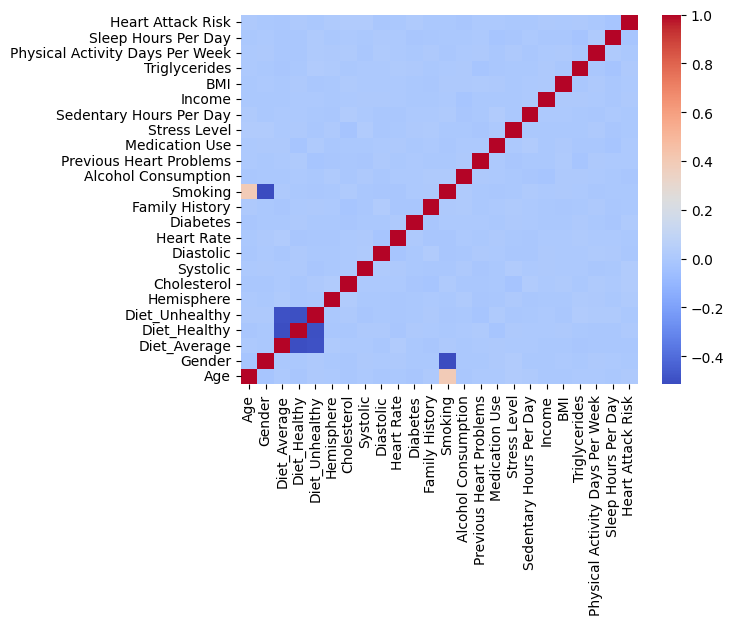

In [12]:
df_corr = df.corr()
fig = sns.heatmap(df_corr, cmap='coolwarm')
fig.invert_yaxis()
plt.show()

In [13]:
# df.cov()
scaler = StandardScaler()
clean_df = pd.DataFrame(scaler.fit_transform(df.iloc[:, 0:(ncols - 1)]))

In [14]:
X = clean_df
y = df.iloc[:, (ncols - 1)]

In [15]:
y.value_counts()

Heart Attack Risk
0    5624
1    3139
Name: count, dtype: int64

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

# Ensemble Methods

## Random Forest

In [17]:
params = {'max_depth': [5, 7, 9],
          'n_estimators': [50, 100, 200]
          }

In [18]:
rf = RandomForestClassifier(random_state=7)

In [19]:
# grid_search = GridSearchCV(rf, params, cv=10, scoring='accuracy', return_train_score=False)
# grid_search.fit(X, y)
# print(grid_search.best_params_)

In [20]:
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
pred_probas_rf = rf.predict_proba(X_test)

In [21]:
print(classification_report(y_test, pred_rf, zero_division=False))

              precision    recall  f1-score   support

           0       0.63      0.98      0.77      1661
           1       0.38      0.03      0.05       968

    accuracy                           0.63      2629
   macro avg       0.51      0.50      0.41      2629
weighted avg       0.54      0.63      0.50      2629



In [22]:
print(accuracy_score(y_test, pred_rf))

0.6260935717002662


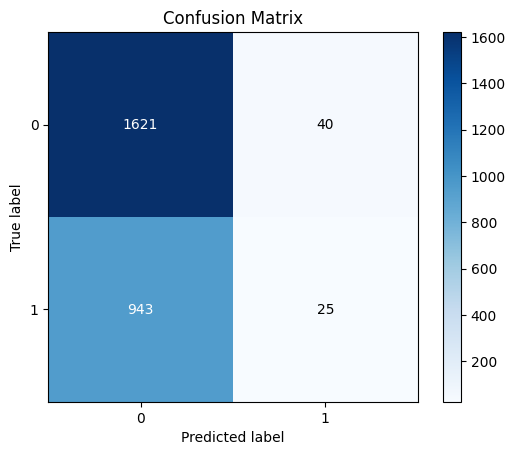

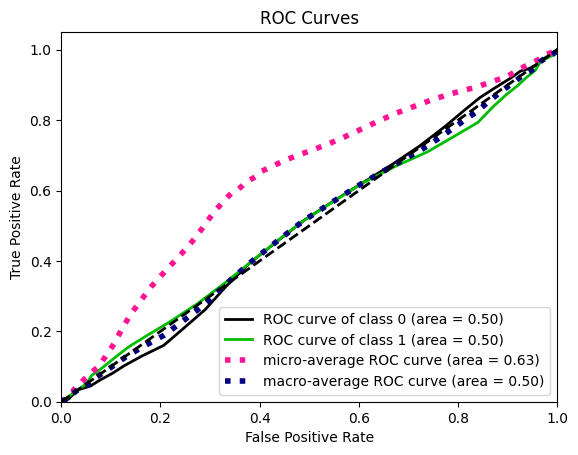

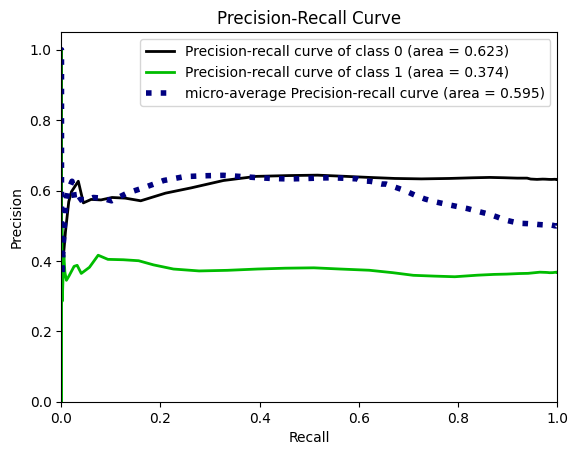

In [23]:
skplt.metrics.plot_confusion_matrix(y_test, pred_rf)
skplt.metrics.plot_roc(y_test, pred_probas_rf)
plot_precision_recall(y_test, pred_probas_rf)
plt.show()

## AdaBoost

In [24]:
ada = AdaBoostClassifier(random_state=7)

In [25]:
params =  {'n_estimators': [50, 100, 150, 200]}

In [26]:
# grid_search1 = GridSearchCV(ada, params, cv=10, scoring='accuracy', return_train_score=False)
# grid_search1.fit(X, y)
# print(grid_search1.best_params_)

In [27]:
ada.fit(X_train, y_train)
pred_ada = ada.predict(X_test)
pred_probas_ada = ada.predict_proba(X_test)

In [28]:
print(classification_report(y_test, pred_ada))

              precision    recall  f1-score   support

           0       0.63      0.99      0.77      1661
           1       0.48      0.02      0.04       968

    accuracy                           0.63      2629
   macro avg       0.55      0.50      0.41      2629
weighted avg       0.58      0.63      0.50      2629



In [29]:
print(accuracy_score(y_test, pred_ada))

0.6310384176492964


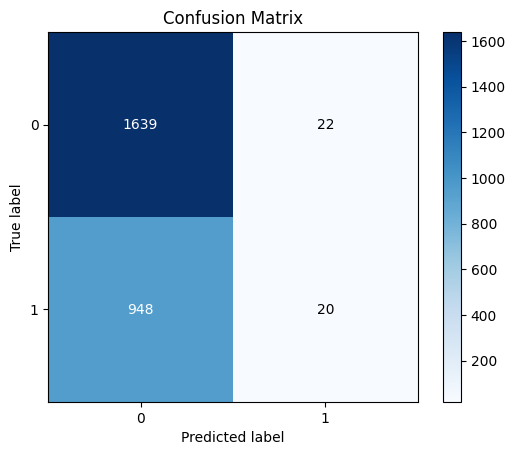

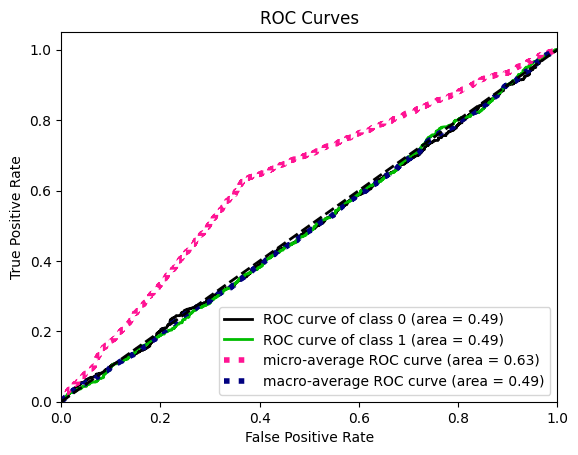

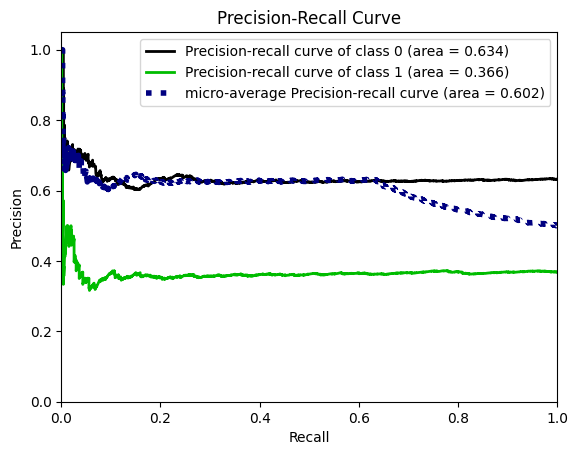

In [30]:
skplt.metrics.plot_confusion_matrix(y_test, pred_ada)
skplt.metrics.plot_roc(y_test, pred_probas_ada)
plot_precision_recall(y_test, pred_probas_ada)
plt.show()

## Bagging

In [31]:
bg = BaggingClassifier(random_state=7)

In [32]:
params =  {'n_estimators': [50, 100, 150, 200]}

In [33]:
# grid_search2 = GridSearchCV(tote_bag, params, cv=10, scoring='accuracy', return_train_score=False)
# grid_search2.fit(X, y)
# print(grid_search2.best_params_)

In [34]:
bg.fit(X_train, y_train)
pred_bg = bg.predict(X_test)
pred_probas_bg = bg.predict_proba(X_test)

In [35]:
print(classification_report(y_test, pred_bg))

              precision    recall  f1-score   support

           0       0.63      0.85      0.72      1661
           1       0.33      0.13      0.19       968

    accuracy                           0.58      2629
   macro avg       0.48      0.49      0.45      2629
weighted avg       0.52      0.58      0.52      2629



In [36]:
print(accuracy_score(y_test, pred_bg))

0.5831114492202358


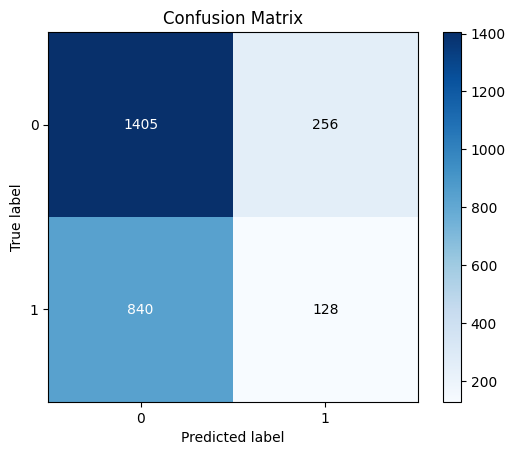

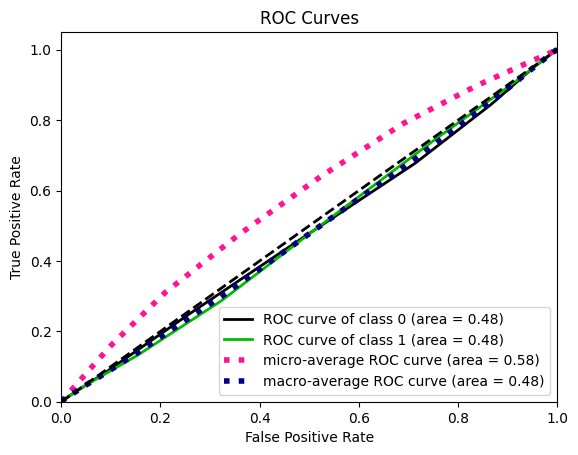

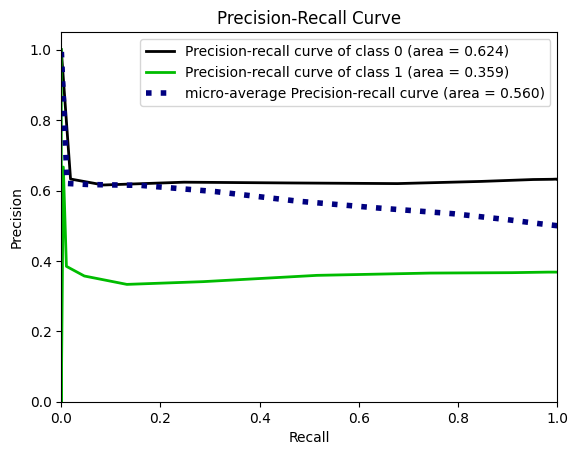

In [37]:
skplt.metrics.plot_confusion_matrix(y_test, pred_bg)
skplt.metrics.plot_roc(y_test, pred_probas_bg)
plot_precision_recall(y_test, pred_probas_bg)
plt.show()

# Modifying the Data

In [38]:
pred_proba_rf = rf.predict_proba(X)
pred_proba_ada = ada.predict_proba(X)
pred_proba_bg = bg.predict_proba(X)

rf_pred_0 = []
ada_pred_0 = []
bg_pred_0 = []

for i, _ in enumerate(pred_proba_rf):
    rf_pred_0.append(pred_proba_rf[i][0])

for j, _ in enumerate(pred_proba_ada):
    ada_pred_0.append(pred_proba_ada[j][0])

for k, _ in enumerate(pred_proba_bg):
    bg_pred_0.append(pred_proba_bg[k][0])

mod_X = X
mod_X['rf_proba_0'] = rf_pred_0
mod_X['ada_proba_0'] = ada_pred_0
mod_X['bg_proba_0'] = bg_pred_0

# ANN

## Original Data

In [58]:
nn_obj_og = NeuralNetwork(activation_func='relu', hidden_layer_sizes=[20,]*3,
                          initialization='random', epochs=50, optimizer='adam', 
                          learning_rate=0.01, lr_decay_type='time', alpha=0.01,
                          random_state=18)

X_og = clean_df.values
y_og = df.iloc[:, (ncols - 1)].values.reshape(-1, 1)

X_og_train, X_og_test, y_og_train, y_og_test = train_test_split(X_og, y_og, test_size=0.3, random_state=7)

fit_og = nn_obj_og.nn_train(X_og_train, y_og_train)
y_og_train_pred = nn_obj_og.nn_predict(X_og_train)
y_og_test_pred = nn_obj_og.nn_predict(X_og_test)

train_accuracy_og = accuracy_score(y_og_train, y_og_train_pred)
test_accuracy_og = accuracy_score(y_og_test, y_og_test_pred)

print("")
print(f"Train Accuracy: {train_accuracy_og}")
print(f"Test Accuracy: {test_accuracy_og}")

Epoch   1 ==================> Loss: 21.6238, Accuracy: 0.3728
Epoch   2 ==================> Loss: 21.1411, Accuracy: 0.3867
Epoch   3 ==================> Loss: 20.4826, Accuracy: 0.4056
Epoch   4 ==================> Loss: 19.7438, Accuracy: 0.4261
Epoch   5 ==================> Loss: 18.9364, Accuracy: 0.4477
Epoch   6 ==================> Loss: 18.1663, Accuracy: 0.4697
Epoch   7 ==================> Loss: 17.8412, Accuracy: 0.4811
Epoch   8 ==================> Loss: 17.3340, Accuracy: 0.4945
Epoch   9 ==================> Loss: 16.9750, Accuracy: 0.5052
Epoch  10 ==================> Loss: 16.5258, Accuracy: 0.5178
Epoch  11 ==================> Loss: 16.1147, Accuracy: 0.5306
Epoch  12 ==================> Loss: 15.8895, Accuracy: 0.5372
Epoch  13 ==================> Loss: 15.6370, Accuracy: 0.5439
Epoch  14 ==================> Loss: 15.3532, Accuracy: 0.5522
Epoch  15 ==================> Loss: 15.1410, Accuracy: 0.5592
Epoch  16 ==================> Loss: 14.9377, Accuracy: 0.5649
Epoch  1

In [59]:
print(classification_report(y_og_test, y_og_test_pred))

              precision    recall  f1-score   support

           0       0.63      0.97      0.76      1661
           1       0.33      0.03      0.05       968

    accuracy                           0.62      2629
   macro avg       0.48      0.50      0.41      2629
weighted avg       0.52      0.62      0.50      2629



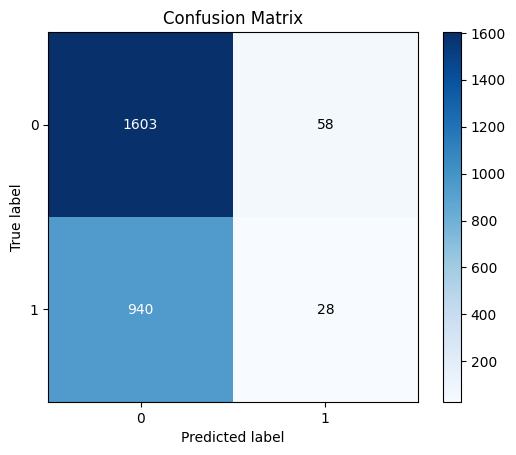

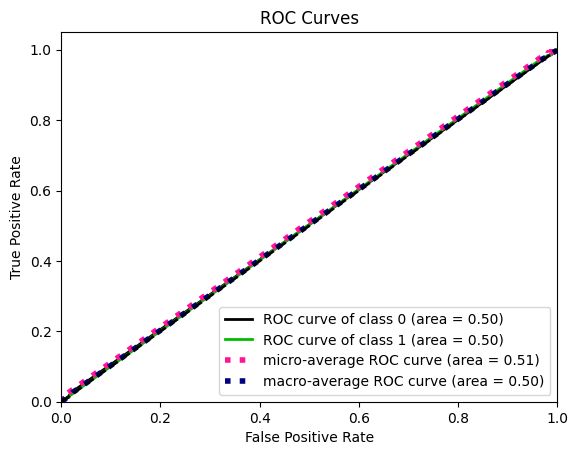

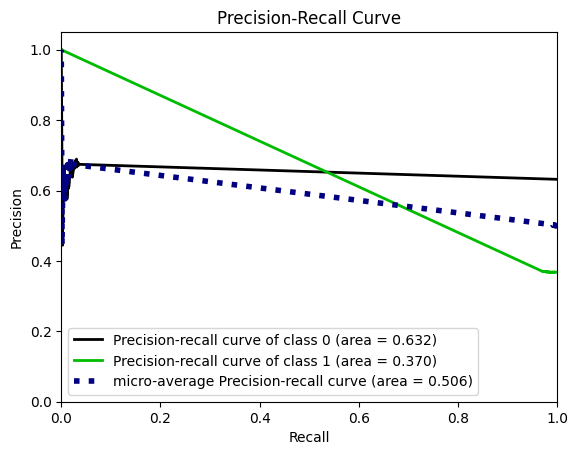

In [60]:
pred_probas_og = nn_obj_og.nn_predict_proba(X_og_test)

skplt.metrics.plot_confusion_matrix(y_og_test, y_og_test_pred)
skplt.metrics.plot_roc(y_og_test, pred_probas_og)
plot_precision_recall(y_og_test, pred_probas_og)
plt.show()

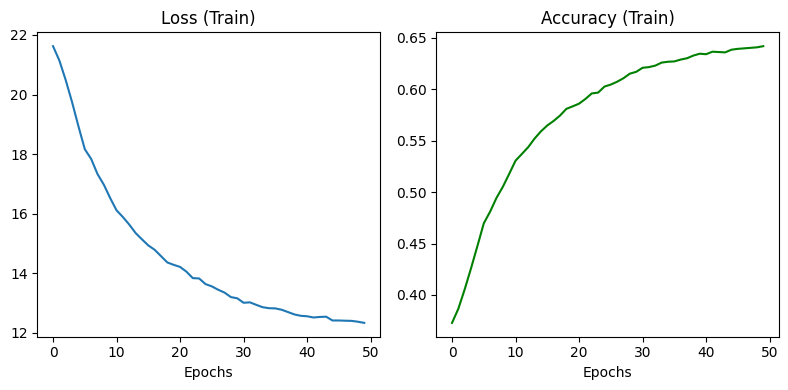

In [61]:
nn_obj_og.plots()

In [44]:
# activation_funcs = ['tanh', 'sigmoid', 'relu', 'linear']
# hidden_layer_sizes = [[100, 100, 100, 100], [100, 50, 100], [100, 75, 100, 20], [100, 100, 80, 120]]
# epochs = [50, 100, 150, 200]
# learning_rate = [0.1, 0.01, 0.05]
# output = []

# for a, hls, e, lr in product(activation_funcs, hidden_layer_sizes, epochs, learning_rate):
#     annFit = nn_obj.nn_train(X_og_train, y_og_train, activation_func=a, 
#                              hidden_layer_sizes=hls, 
#                              epochs=e, learning_rate=lr)
    
#     train_accuratooot = accuracy_score(y_og_train, np.round(nn_obj.nn_predict(X_og_train)) == y_og_train)
#     test_accuratooot = accuracy_score(y_og_test, np.round(nn_obj.nn_predict(X_og_test)) == y_og_test)

#     output_dict = {
#                     'Activation': a,
#                     'Learning Rate': lr,
#                     'Number Epochs': e,
#                     'Hidden Layers': hls,
#                     'Train Accuracy': train_accuratooot,
#                     'Test Accuracy': test_accuratooot
#                   }

#     output.append(output_dict)

In [45]:
# out_df = pd.DataFrame(output)
# out_df = out_df.sort_values(by=['Test Accuracy'], ascending=False)
# out_df.head()

In [46]:
# out_df.to_csv("data/ann_out.csv", index=False)

## Modded Data

In [47]:
nn_obj_mod = NeuralNetwork(activation_func='relu', hidden_layer_sizes=[20,]*3,
                           initialization='random', epochs=50, optimizer='adam', 
                           learning_rate=0.01, lr_decay_type='time', alpha=0.01,
                           random_state=18)
X_mod = mod_X.values
y_mod = df.iloc[:, (ncols - 1)].values.reshape(-1, 1)

X_mod_train, X_mod_test, y_mod_train, y_mod_test = train_test_split(X_mod, y_mod, test_size=0.3, random_state=7)

fit_mod = nn_obj_mod.nn_train(X_mod_train, y_mod_train)

y_mod_train_pred = nn_obj_mod.nn_predict(X_mod_train)
y_mod_test_pred = nn_obj_mod.nn_predict(X_mod_test)

train_accuracy_mod = accuracy_score(y_mod_train, y_mod_train_pred)
test_accuracy_mod = accuracy_score(y_mod_test, y_mod_test_pred)

print("")
print(f"Train Accuracy: {train_accuracy_mod}")
print(f"Test Accuracy: {test_accuracy_mod}")

Epoch   1 ==================> Loss: 21.6238, Accuracy: 0.3728
Epoch   2 ==================> Loss: 21.1411, Accuracy: 0.3867
Epoch   3 ==================> Loss: 20.4826, Accuracy: 0.4056
Epoch   4 ==================> Loss: 19.7438, Accuracy: 0.4261
Epoch   5 ==================> Loss: 18.9364, Accuracy: 0.4477
Epoch   6 ==================> Loss: 18.1663, Accuracy: 0.4697
Epoch   7 ==================> Loss: 17.8412, Accuracy: 0.4811
Epoch   8 ==================> Loss: 17.3340, Accuracy: 0.4945
Epoch   9 ==================> Loss: 16.9750, Accuracy: 0.5052
Epoch  10 ==================> Loss: 16.5258, Accuracy: 0.5178
Epoch  11 ==================> Loss: 16.1147, Accuracy: 0.5306
Epoch  12 ==================> Loss: 15.8895, Accuracy: 0.5372
Epoch  13 ==================> Loss: 15.6370, Accuracy: 0.5439
Epoch  14 ==================> Loss: 15.3532, Accuracy: 0.5522
Epoch  15 ==================> Loss: 15.1410, Accuracy: 0.5592
Epoch  16 ==================> Loss: 14.9377, Accuracy: 0.5649
Epoch  1

In [48]:
print(classification_report(y_mod_test, y_mod_test_pred))

              precision    recall  f1-score   support

           0       0.63      0.97      0.76      1661
           1       0.33      0.03      0.05       968

    accuracy                           0.62      2629
   macro avg       0.48      0.50      0.41      2629
weighted avg       0.52      0.62      0.50      2629



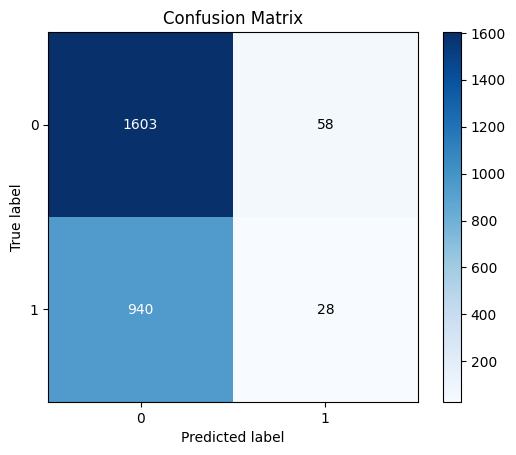

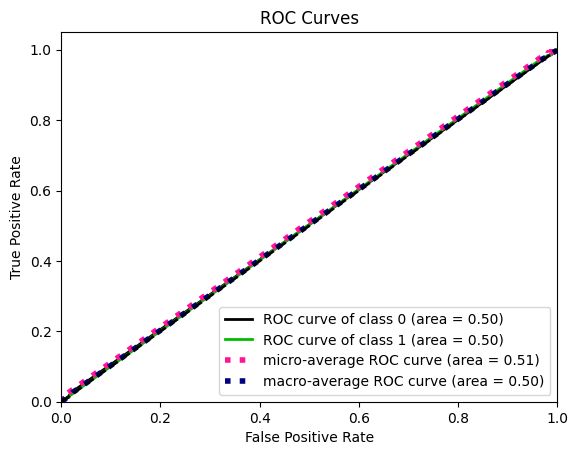

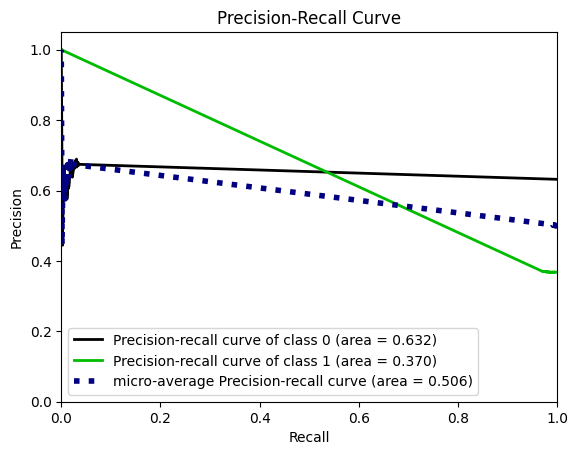

In [49]:
pred_probas_mod = nn_obj_mod.nn_predict_proba(X_mod_test)

skplt.metrics.plot_confusion_matrix(y_mod_test, y_mod_test_pred)
skplt.metrics.plot_roc(y_mod_test, pred_probas_mod)
plot_precision_recall(y_mod_test, pred_probas_mod)
plt.show()

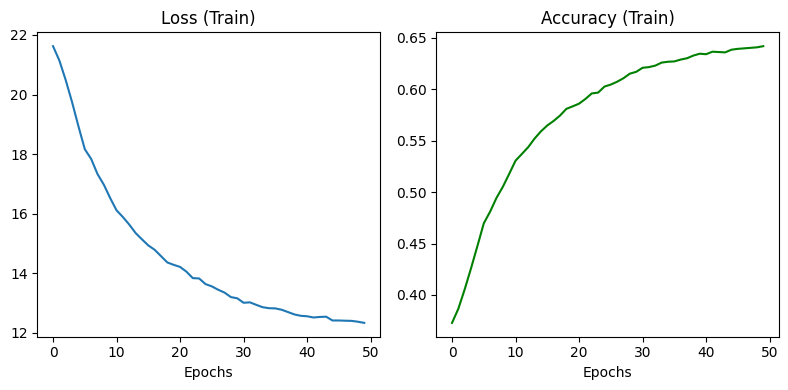

In [50]:
nn_obj_mod.plots()

In [51]:
nn_obj_mod.get_params()

{'activation_func': 'relu',
 'hidden_layer_sizes': [20, 20, 20],
 'initialization': 'random',
 'epochs': 50,
 'optimizer': 'adam',
 'learning_rate': 0.01,
 'lr_decay_type': 'time',
 'lr_decrease': 0.5,
 'lr_epoch_drop': 5,
 'alpha': 0.01,
 'regularization': 'l2',
 'tolerance': 0.0001,
 'tolerance_counter': 10,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-08,
 'random_state': 18}

In [52]:
# activation_funcs = ['sigmoid']
# hidden_layer_sizes = [[20, 20, 20], [50, 50, 50]]
# initializations = ['xavier', 'he', 'random']
# epochs = [50, 100]
# optimizers = ['adam', 'sgd']
# learning_rates = [0.01, 0.05]
# decay_types = ['step', 'exponential', 'time']
# alphas = [0.01]
# regularizations = ['l1', 'l2']

# output = []

# kf = KFold(n_splits=4, shuffle=True, random_state=7)

# for af, hls, i, e, o, lr, dt, ral, r in product(activation_funcs, hidden_layer_sizes, initializations, 
#                                                 epochs, optimizers, learning_rates, decay_types,
#                                                 alphas, regularizations):
#     nn_test = NeuralNetwork(activation_func=af, hidden_layer_sizes=hls, 
#                             initialization=i, epochs=e, optimizer=o, 
#                             learning_rate=lr, decay_type=dt, lr_decrease=0.5, 
#                             lr_epoch_drop=5, alpha=ral, regularization=r)
#     accuracy_train_values = []
#     accuracy_test_values = []

#     for train_index, val_index in kf.split(X_mod):
#         X_train_fold, X_val_fold = X_mod[train_index], X_mod[val_index]
#         y_train_fold, y_val_fold = y_mod[train_index], y_mod[val_index]

#         fit = nn_test.nn_train(X_train_fold, y_train_fold, verbose=False)
#         y_train_pred = nn_test.nn_predict(X_train_fold)
#         y_test_pred = nn_test.nn_predict(X_val_fold)
        
#         accuracy_train = accuracy_score(y_train_fold, y_train_pred)
#         accuracy_train_values.append(accuracy_train)

#         accuracy_test = accuracy_score(y_val_fold, y_test_pred)
#         accuracy_test_values.append(accuracy_test)

#     average_train_accuracy = np.mean(accuracy_train_values)
#     average_test_accuracy = np.mean(accuracy_test_values)

#     output_dict = {'Parameters': nn_test.get_params(), 'Train/Test Split': '75-25', 
#                    'Dataset Size': '(8764, 26)', 'Train Accuracy': average_train_accuracy,
#                    'Test Accuracy': average_test_accuracy}
#     output.append(output_dict)

In [53]:
# out_df = pd.DataFrame(output)
# out_df = out_df.sort_values(by=['Test Accuracy'], ascending=False)
# out_df.to_csv("data/final_out_mod_s.csv", index=False)

# Best Parameters

In [54]:
best_params_s = {'activation_func': 'sigmoid', 
                 'hidden_layer_sizes': [20, 20, 20], 
                 'initialization': 'he', 
                 'epochs': 100, 
                 'optimizer': 'adam', 
                 'learning_rate': 0.05, 
                 'lr_decay_type': 'time', 
                 'lr_decrease': 0.5, 
                 'lr_epoch_drop': 5, 
                 'alpha': 0.01, 
                 'regularization': 'l2', 
                 'tolerance': 0.0001, 
                 'tolerance_counter': 10, 
                 'beta_1': 0.9, 
                 'beta_2': 0.999, 
                 'epsilon': 1e-08, 
                 'random_state': 18}

best_params_t = {'activation_func': 'tanh', 
                 'hidden_layer_sizes': [20, 20, 20], 
                 'initialization': 'he', 
                 'epochs': 50, 
                 'optimizer': 'sgd', 
                 'learning_rate': 0.01, 
                 'lr_decay_type': 'time', 
                 'lr_decrease': 0.5, 
                 'lr_epoch_drop': 5, 
                 'alpha': 0.01, 
                 'regularization': 'l2', 
                 'tolerance': 0.0001, 
                 'tolerance_counter': 10, 
                 'beta_1': 0.9, 
                 'beta_2': 0.999, 
                 'epsilon': 1e-08, 
                 'random_state': 18}

best_params_r = {'activation_func': 'relu', 
                 'hidden_layer_sizes': [50, 50, 50], 
                 'initialization': 'random', 
                 'epochs': 100, 
                 'optimizer': 'adam', 
                 'learning_rate': 0.01, 
                 'lr_decay_type': 'time', 
                 'lr_decrease': 0.5, 
                 'lr_epoch_drop': 5, 
                 'alpha': 0.01, 
                 'regularization': 'l1', 
                 'tolerance': 0.0001, 
                 'tolerance_counter': 10, 
                 'beta_1': 0.9, 
                 'beta_2': 0.999, 
                 'epsilon': 1e-08, 
                 'random_state': 18}

kf = KFold(n_splits=4, shuffle=True, random_state=7)

# Best Sigmoid

              precision    recall  f1-score   support

           0       0.62      0.72      0.67      1372
           1       0.35      0.25      0.29       819

    accuracy                           0.55      2191
   macro avg       0.48      0.49      0.48      2191
weighted avg       0.52      0.55      0.53      2191



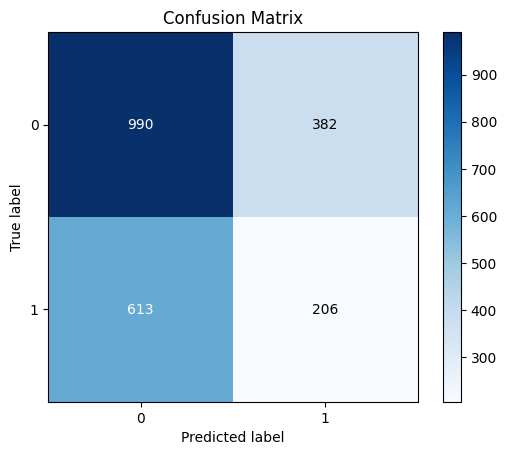

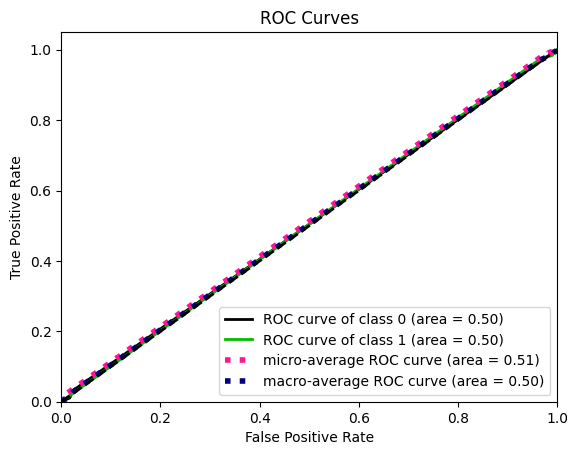

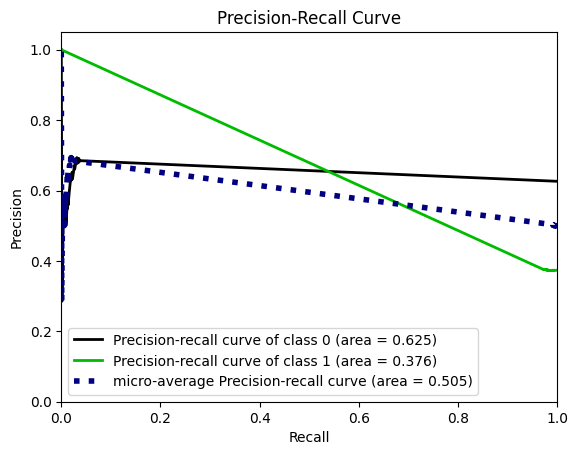

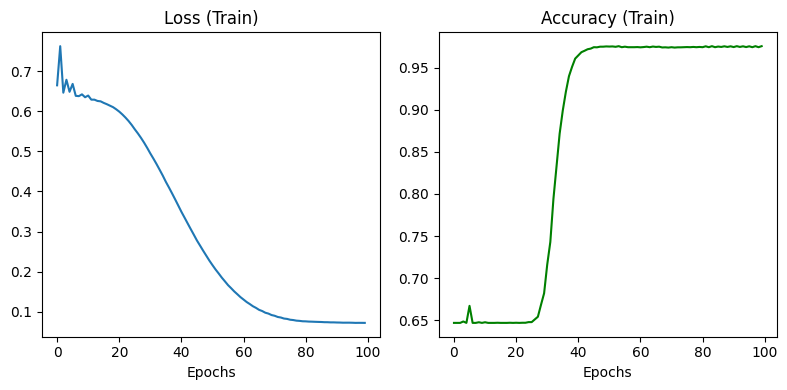

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1432
           1       0.95      0.82      0.88       759

    accuracy                           0.92      2191
   macro avg       0.93      0.90      0.91      2191
weighted avg       0.93      0.92      0.92      2191



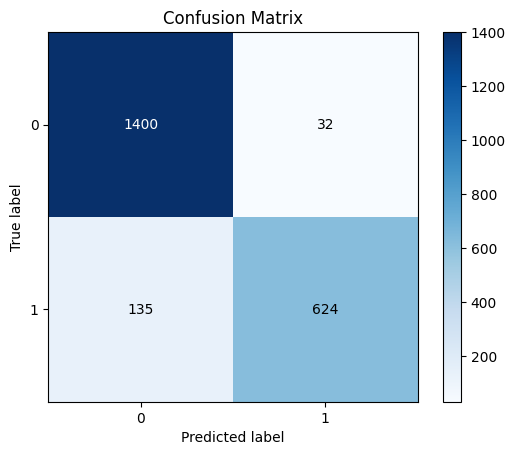

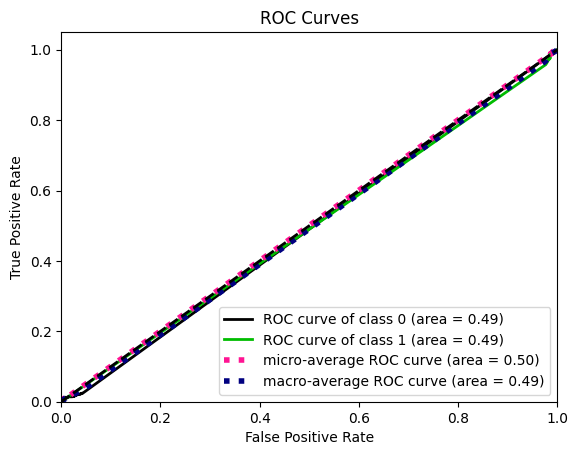

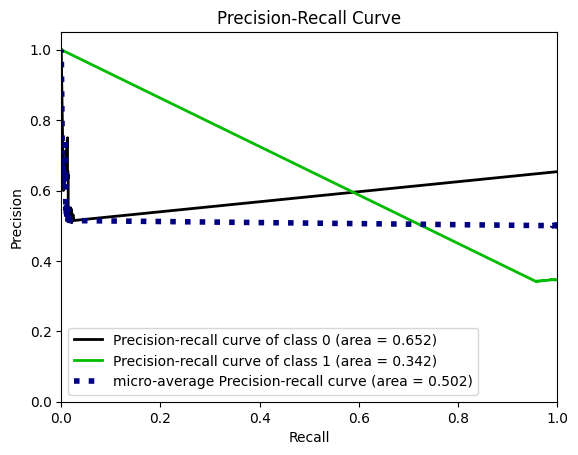

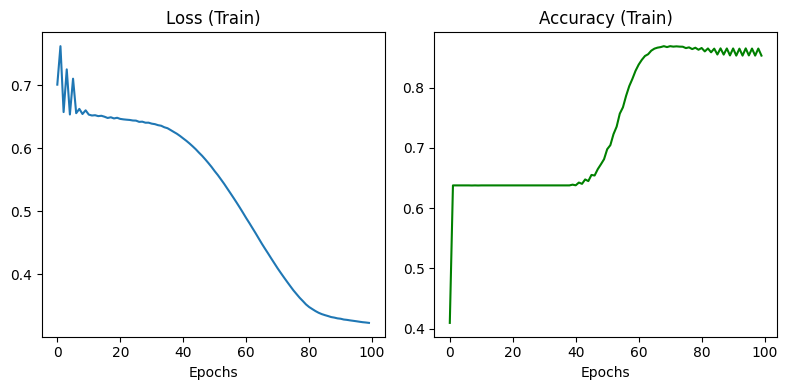

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1408
           1       1.00      1.00      1.00       783

    accuracy                           1.00      2191
   macro avg       1.00      1.00      1.00      2191
weighted avg       1.00      1.00      1.00      2191



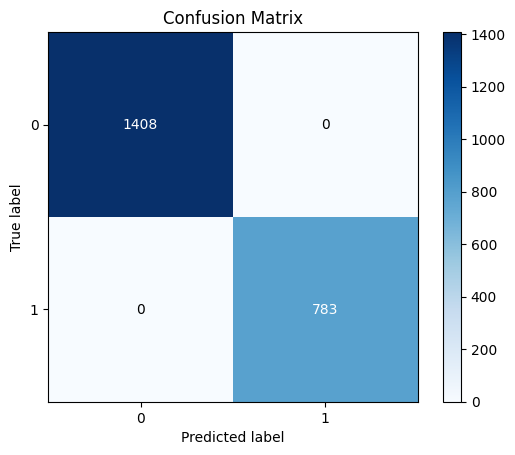

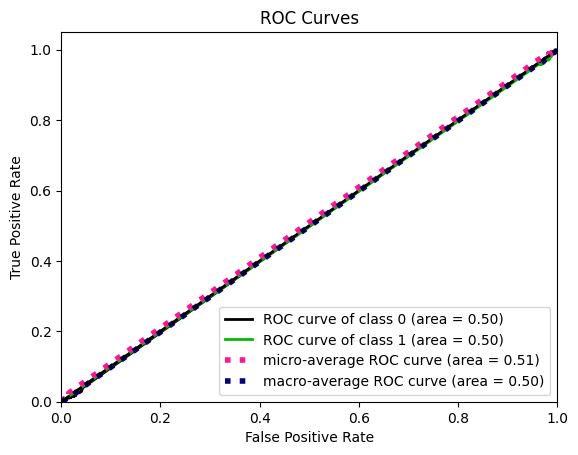

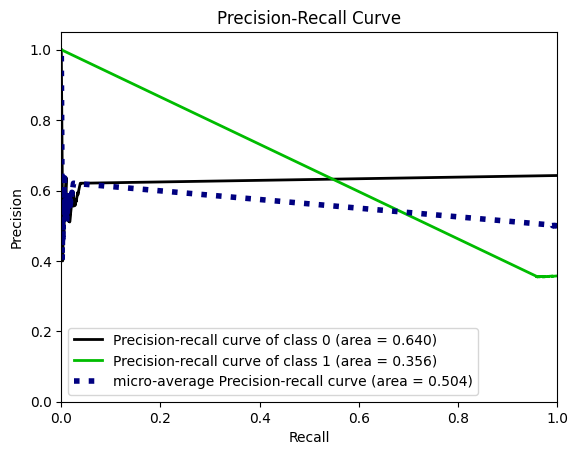

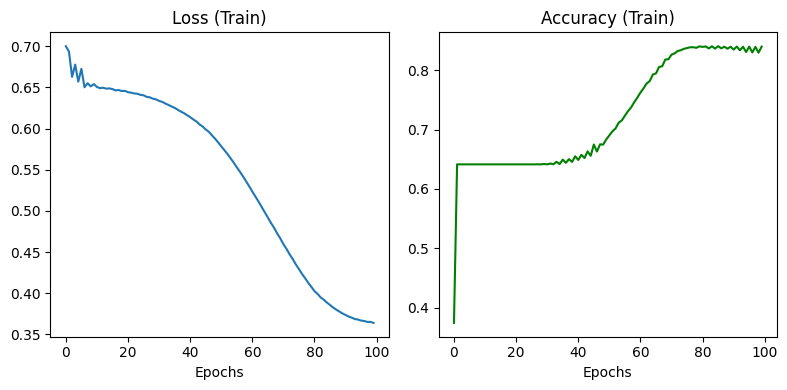

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1412
           1       1.00      1.00      1.00       778

    accuracy                           1.00      2190
   macro avg       1.00      1.00      1.00      2190
weighted avg       1.00      1.00      1.00      2190



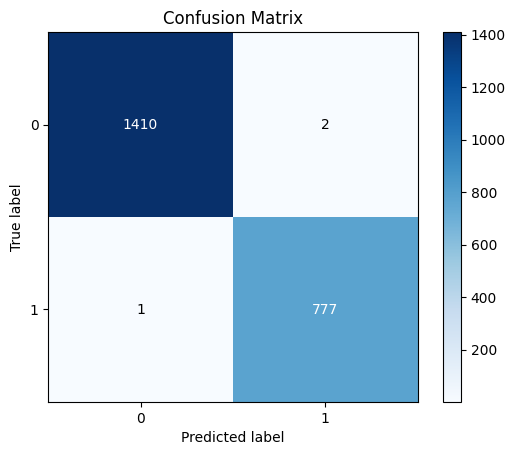

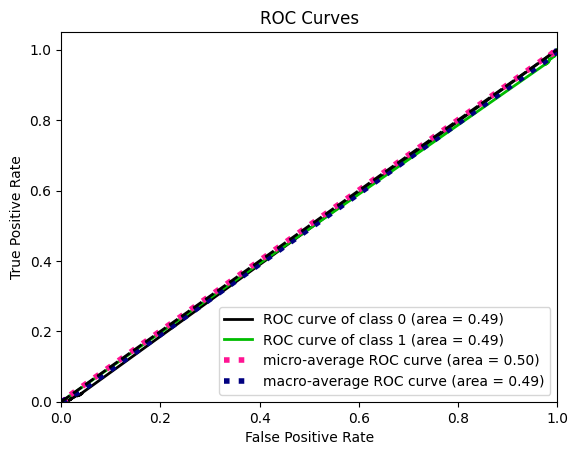

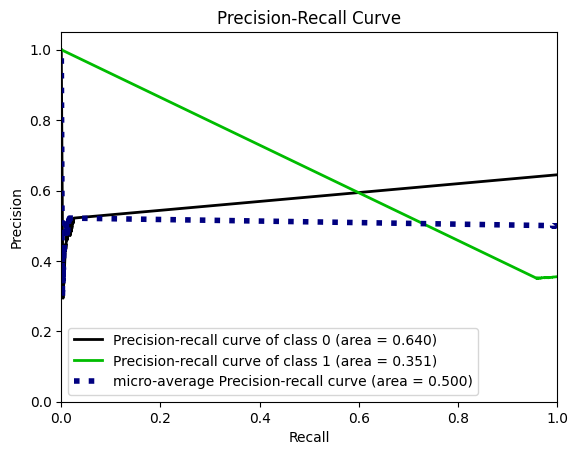

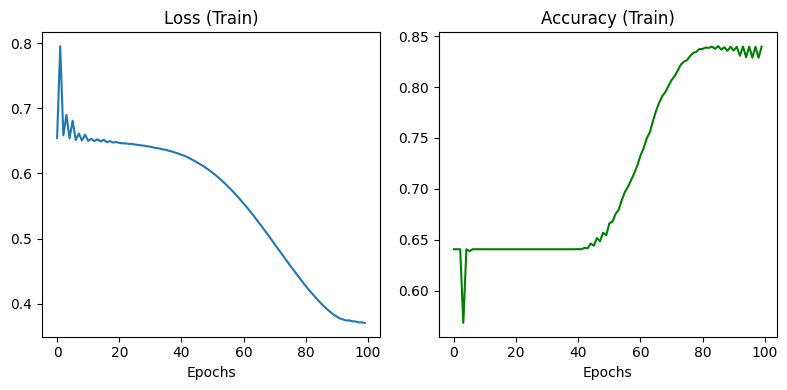

0.8670696748216552
0.8670696748216552


In [55]:
nn_final_s = NeuralNetwork()
nn_final_s.set_params(best_params_s)
accuracy_train_values_s = []
accuracy_test_values_s = []

for train_index, test_index in kf.split(X_mod):
    X_train_fold, X_test_fold = X_mod[train_index], X_mod[test_index]
    y_train_fold, y_test_fold = y_mod[train_index], y_mod[test_index]

    fit = nn_final_s.nn_train(X_train_fold, y_train_fold, verbose=False)
    y_train_pred = nn_final_s.nn_predict(X_train_fold)
    y_test_pred = nn_final_s.nn_predict(X_test_fold)
    
    accuracy_train = accuracy_score(y_train_fold, y_train_pred)
    accuracy_train_values_s.append(accuracy_train)

    accuracy_test = accuracy_score(y_test_fold, y_test_pred)
    accuracy_test_values_s.append(accuracy_test)

    print(classification_report(y_test_fold, y_test_pred))
    pred_proba_s = nn_obj_mod.nn_predict_proba(X_test_fold)

    skplt.metrics.plot_confusion_matrix(y_test_fold, y_test_pred)
    skplt.metrics.plot_roc(y_test_fold, pred_proba_s)
    plot_precision_recall(y_test_fold, pred_proba_s)
    plt.show()

    nn_final_s.plots()

average_train_accuracy_s = np.mean(accuracy_train_values_s)
average_test_accuracy_s = np.mean(accuracy_test_values_s)

print(average_test_accuracy_s)
print(average_test_accuracy_s)


# Best Tanh

              precision    recall  f1-score   support

           0       0.62      0.12      0.20      1372
           1       0.37      0.88      0.52       819

    accuracy                           0.40      2191
   macro avg       0.50      0.50      0.36      2191
weighted avg       0.53      0.40      0.32      2191



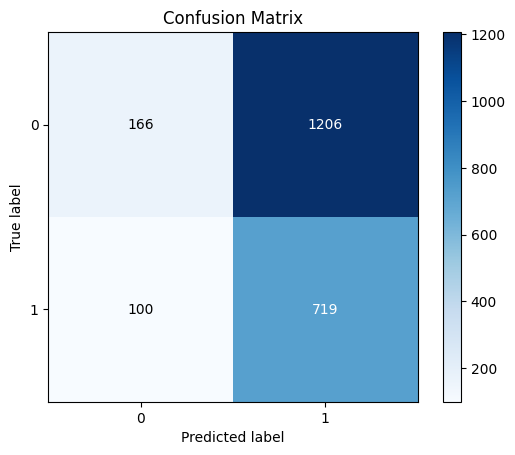

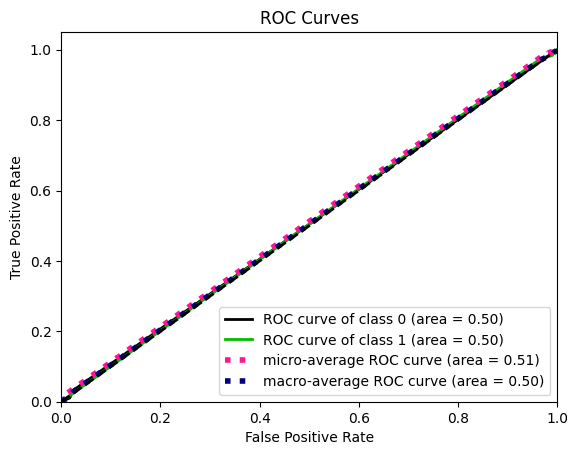

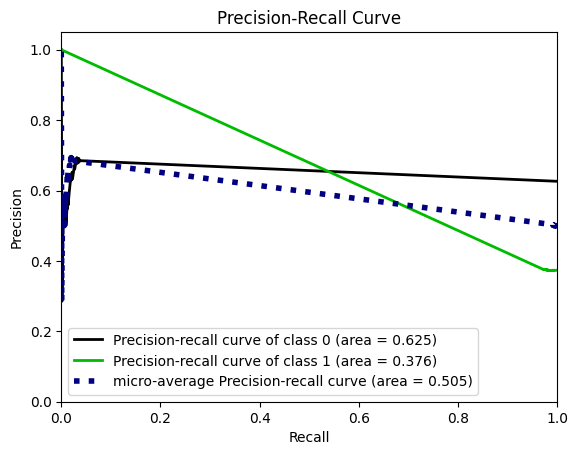

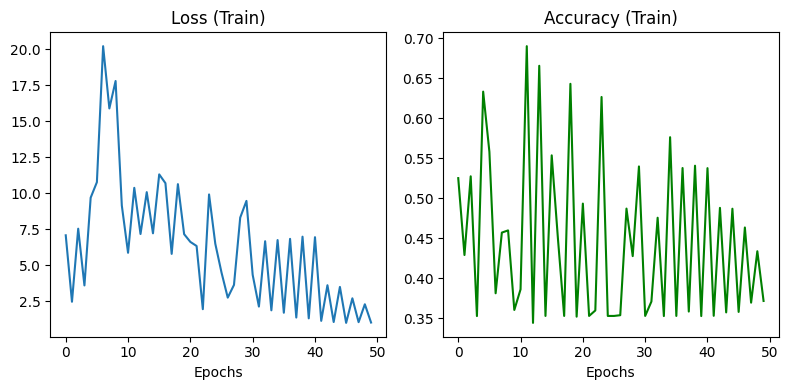

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1432
           1       0.88      0.85      0.86       759

    accuracy                           0.91      2191
   macro avg       0.90      0.89      0.90      2191
weighted avg       0.91      0.91      0.91      2191



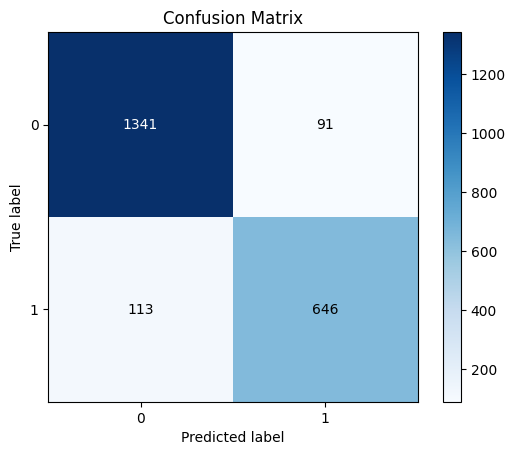

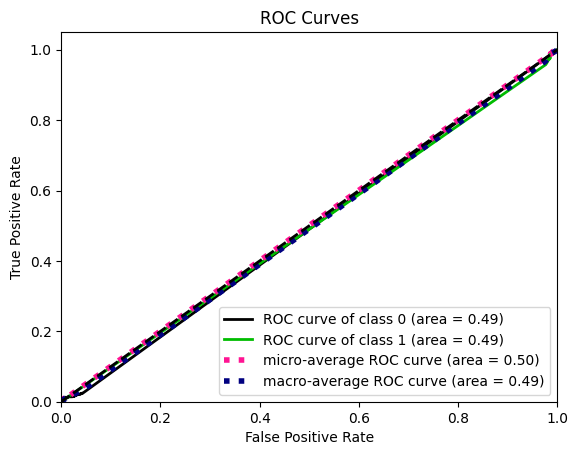

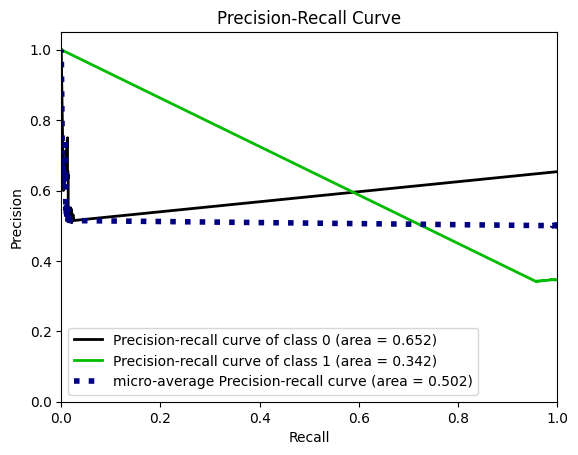

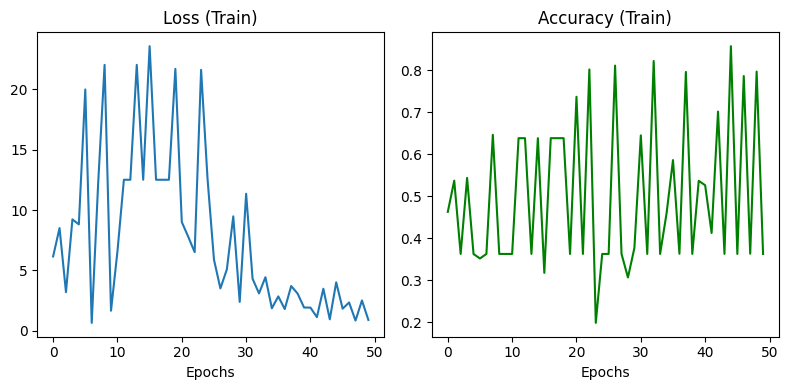

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1408
           1       0.36      1.00      0.53       783

    accuracy                           0.36      2191
   macro avg       0.18      0.50      0.26      2191
weighted avg       0.13      0.36      0.19      2191



/opt/miniconda3/envs/machine_learning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/machine_learning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/machine_learning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

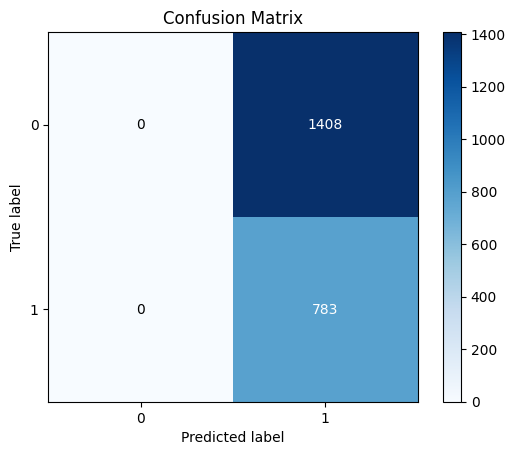

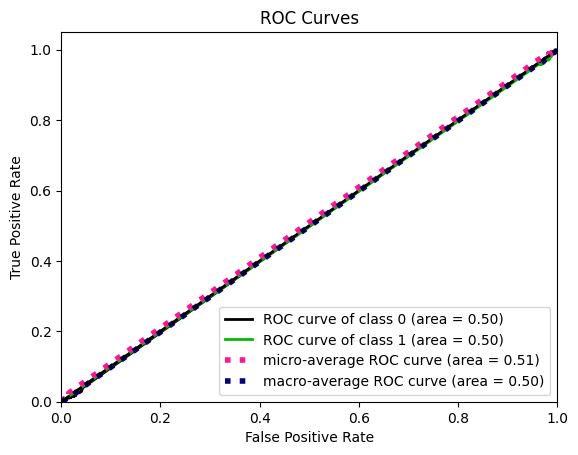

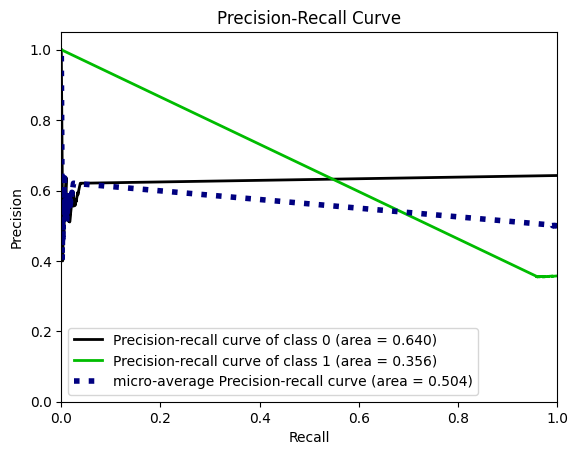

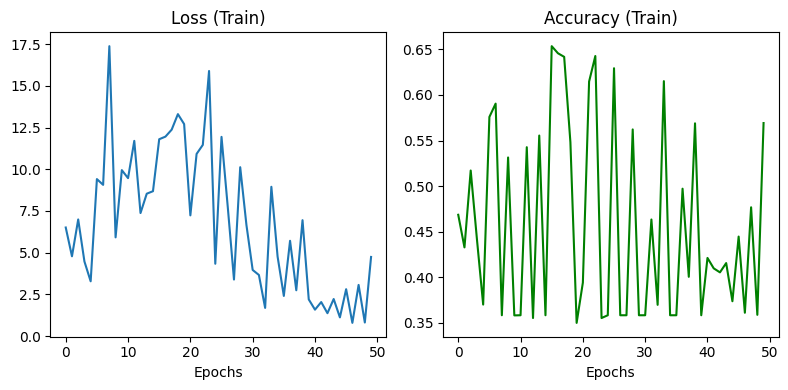

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1412
           1       0.36      1.00      0.52       778

    accuracy                           0.36      2190
   macro avg       0.18      0.50      0.26      2190
weighted avg       0.13      0.36      0.19      2190



/opt/miniconda3/envs/machine_learning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/machine_learning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/envs/machine_learning/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

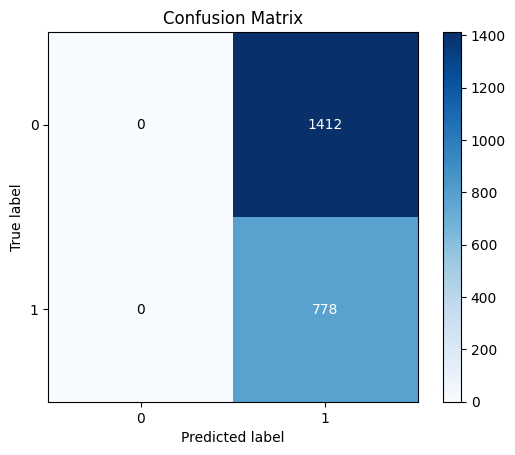

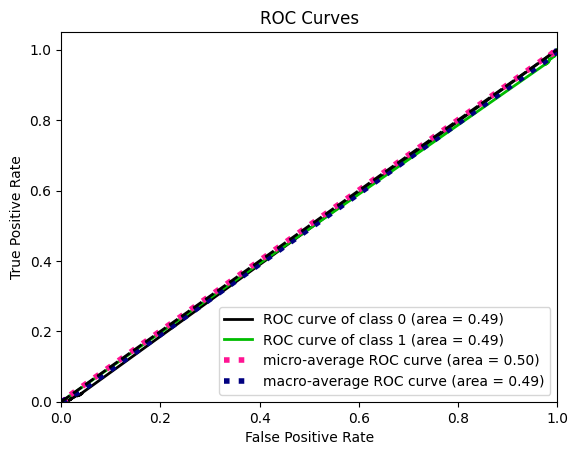

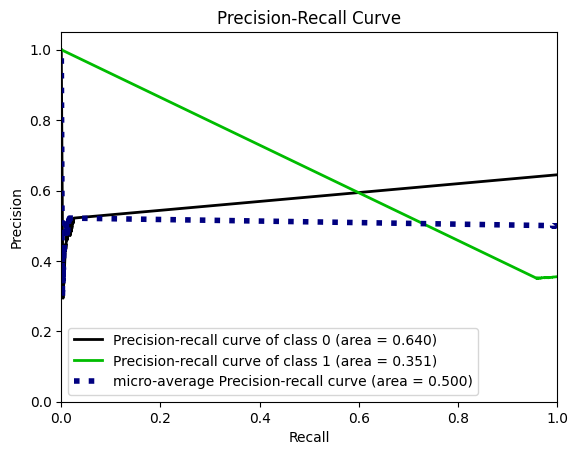

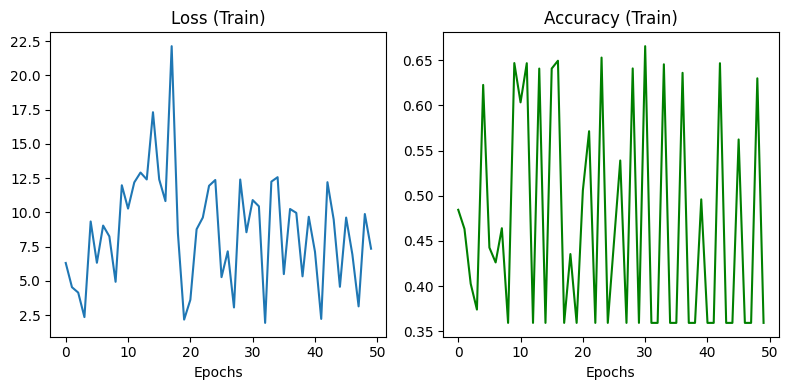

0.49127513706962
0.5058597958856176


In [56]:
nn_final_t = NeuralNetwork()
nn_final_t.set_params(best_params_t)
accuracy_train_values_t = []
accuracy_test_values_t = []

for train_index, test_index in kf.split(X_mod):
    X_train_fold, X_test_fold = X_mod[train_index], X_mod[test_index]
    y_train_fold, y_test_fold = y_mod[train_index], y_mod[test_index]

    fit = nn_final_t.nn_train(X_train_fold, y_train_fold, verbose=False)
    y_train_pred = nn_final_t.nn_predict(X_train_fold)
    y_test_pred = nn_final_t.nn_predict(X_test_fold)
    
    accuracy_train = accuracy_score(y_train_fold, y_train_pred)
    accuracy_train_values_t.append(accuracy_train)

    accuracy_test = accuracy_score(y_test_fold, y_test_pred)
    accuracy_test_values_t.append(accuracy_test)

    print(classification_report(y_test_fold, y_test_pred))
    pred_proba_t = nn_obj_mod.nn_predict_proba(X_test_fold)

    skplt.metrics.plot_confusion_matrix(y_test_fold, y_test_pred)
    skplt.metrics.plot_roc(y_test_fold, pred_proba_t)
    plot_precision_recall(y_test_fold, pred_proba_t)
    plt.show()

    nn_final_t.plots()

average_train_accuracy_t = np.mean(accuracy_train_values_t)
average_test_accuracy_t = np.mean(accuracy_test_values_t)

print(average_train_accuracy_t)
print(average_test_accuracy_t)

# Best ReLU

              precision    recall  f1-score   support

           0       0.63      0.99      0.77      1372
           1       0.53      0.01      0.02       819

    accuracy                           0.63      2191
   macro avg       0.58      0.50      0.40      2191
weighted avg       0.59      0.63      0.49      2191



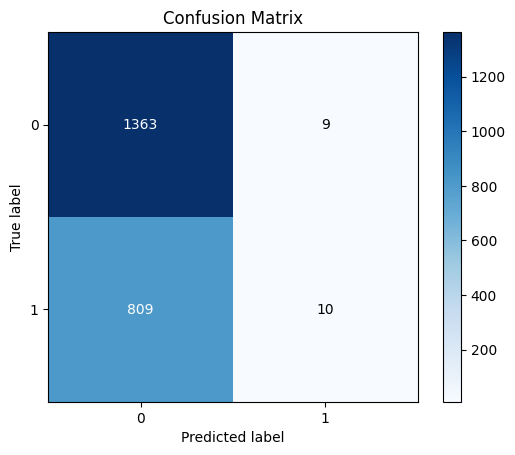

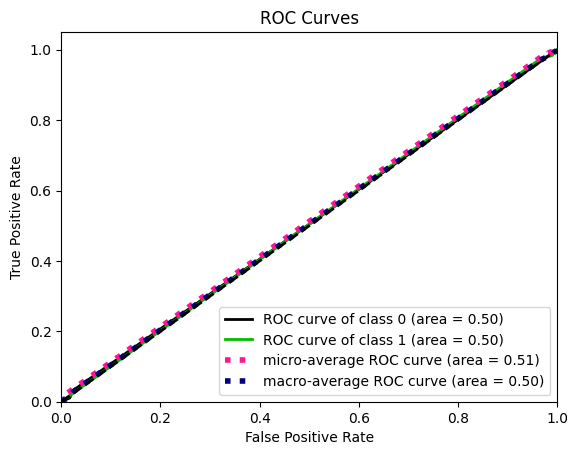

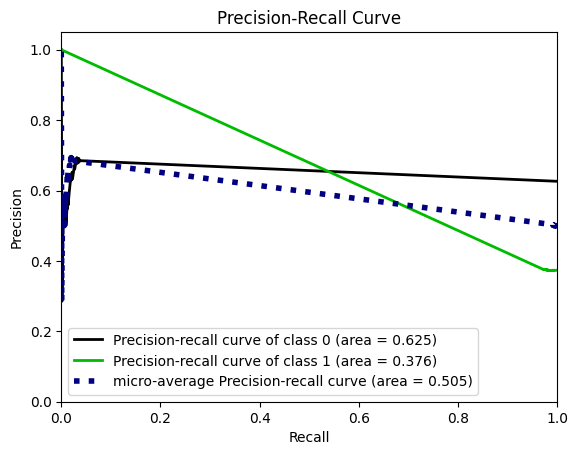

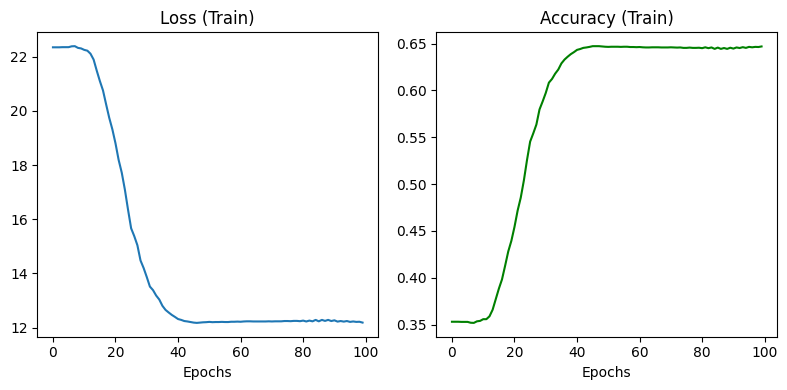

              precision    recall  f1-score   support

           0       0.65      0.99      0.79      1432
           1       0.45      0.02      0.03       759

    accuracy                           0.65      2191
   macro avg       0.55      0.50      0.41      2191
weighted avg       0.58      0.65      0.53      2191



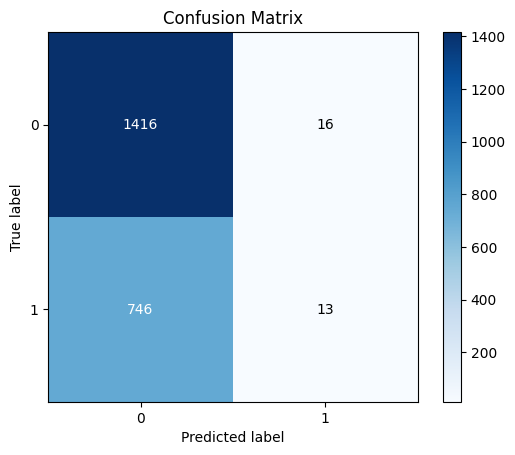

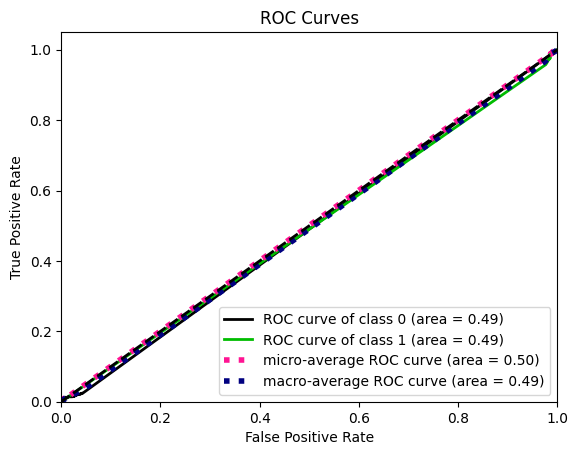

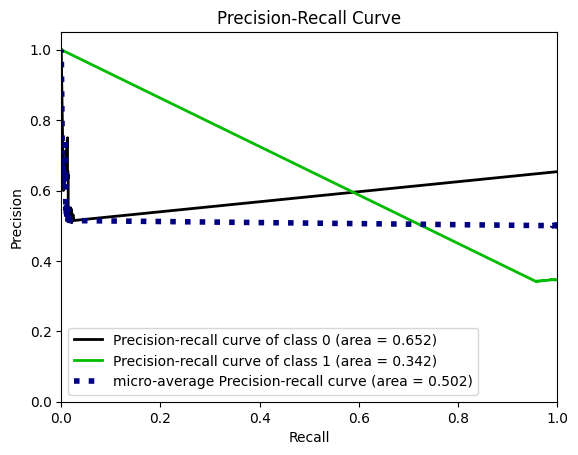

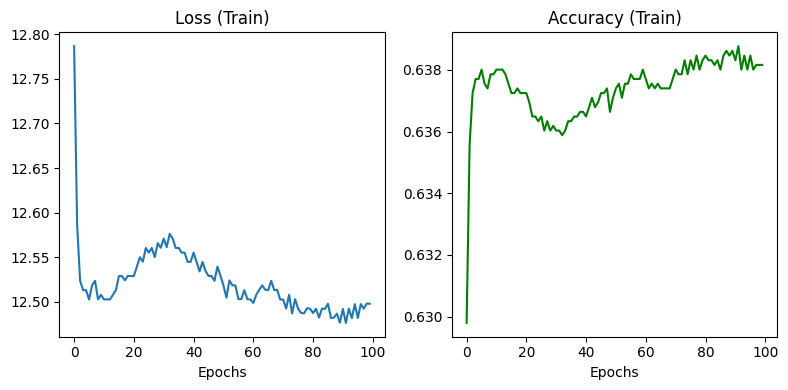

              precision    recall  f1-score   support

           0       0.64      0.99      0.78      1408
           1       0.44      0.01      0.02       783

    accuracy                           0.64      2191
   macro avg       0.54      0.50      0.40      2191
weighted avg       0.57      0.64      0.51      2191



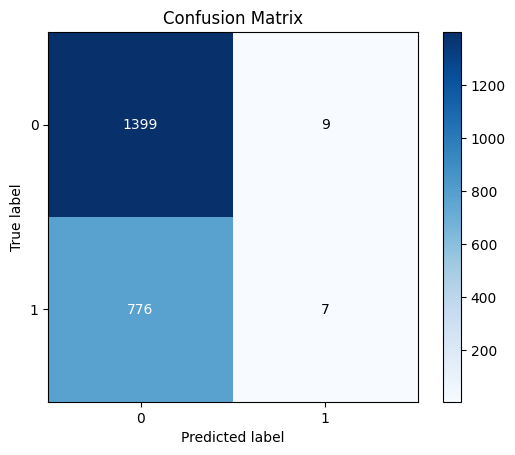

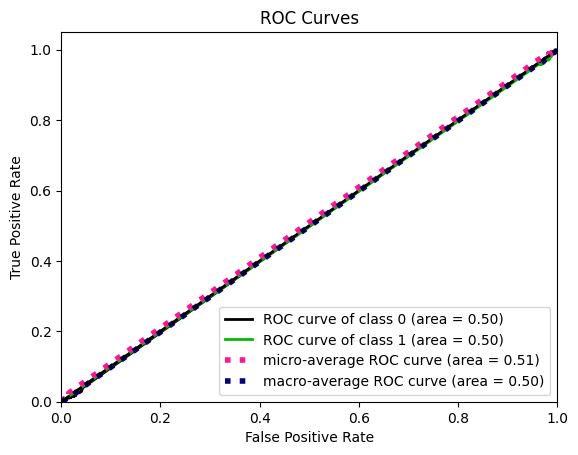

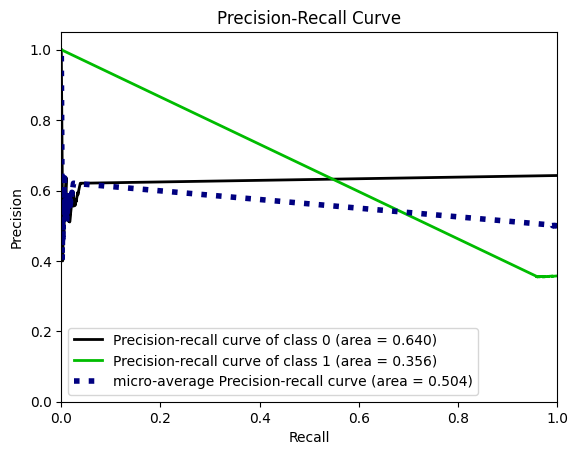

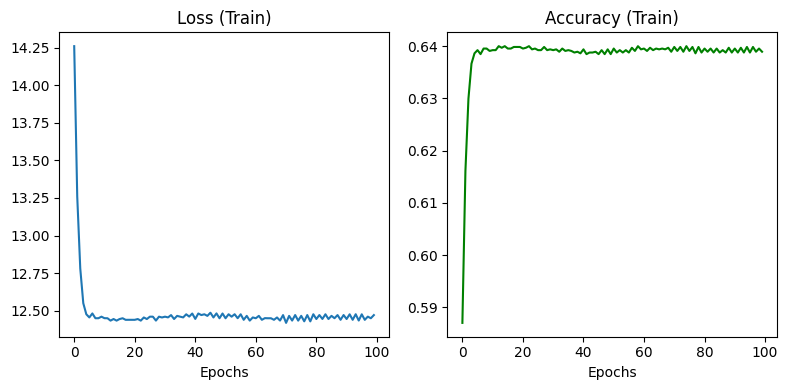

              precision    recall  f1-score   support

           0       0.65      0.99      0.78      1412
           1       0.62      0.02      0.04       778

    accuracy                           0.65      2190
   macro avg       0.64      0.51      0.41      2190
weighted avg       0.64      0.65      0.52      2190



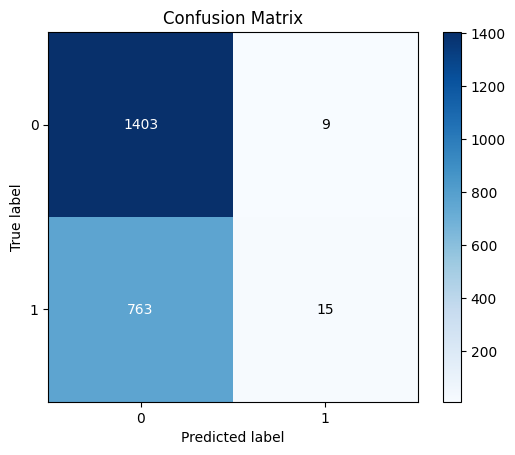

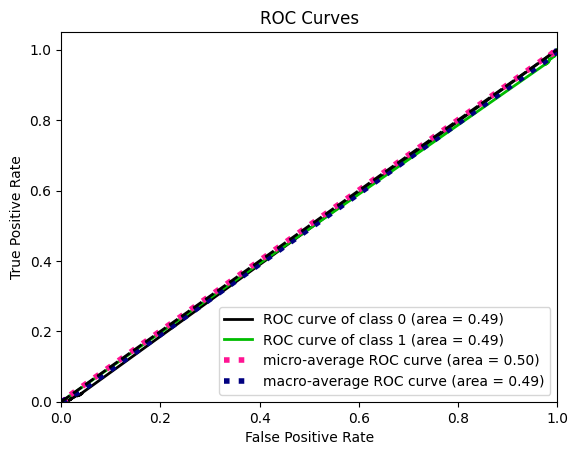

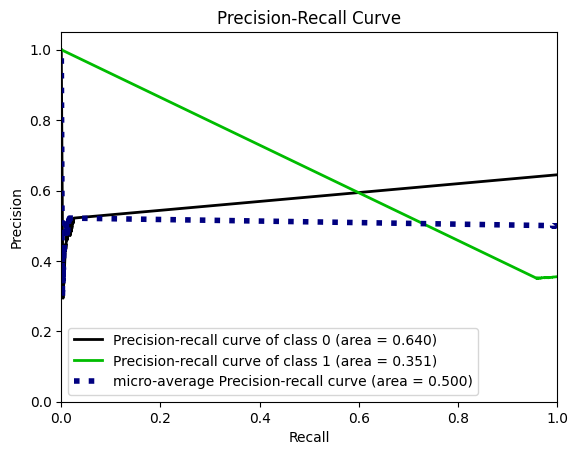

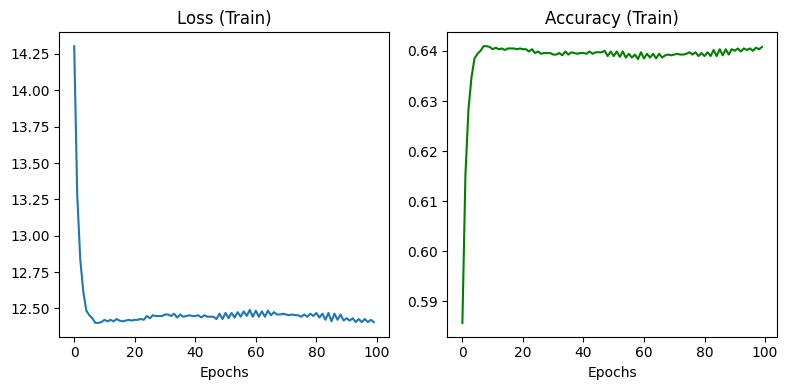

0.6411046733538659
0.6420181981497576


In [57]:
nn_final_r = NeuralNetwork()
nn_final_r.set_params(best_params_r)
accuracy_train_values_r = []
accuracy_test_values_r = []
kf = KFold(n_splits=4, shuffle=True, random_state=7)

for train_index, test_index in kf.split(X_mod):
    X_train_fold, X_test_fold = X_mod[train_index], X_mod[test_index]
    y_train_fold, y_test_fold = y_mod[train_index], y_mod[test_index]

    fit = nn_final_r.nn_train(X_train_fold, y_train_fold, verbose=False)
    y_train_pred = nn_final_r.nn_predict(X_train_fold)
    y_test_pred = nn_final_r.nn_predict(X_test_fold)
    
    accuracy_train = accuracy_score(y_train_fold, y_train_pred)
    accuracy_train_values_r.append(accuracy_train)

    accuracy_test = accuracy_score(y_test_fold, y_test_pred)
    accuracy_test_values_r.append(accuracy_test)

    print(classification_report(y_test_fold, y_test_pred))
    pred_proba_r = nn_obj_mod.nn_predict_proba(X_test_fold)

    skplt.metrics.plot_confusion_matrix(y_test_fold, y_test_pred)
    skplt.metrics.plot_roc(y_test_fold, pred_proba_r)
    plot_precision_recall(y_test_fold, pred_proba_r)
    plt.show()

    nn_final_r.plots()

average_train_accuracy_r = np.mean(accuracy_train_values_r)
average_test_accuracy_r = np.mean(accuracy_test_values_r)

print(average_train_accuracy_r)
print(average_test_accuracy_r)